## Sentiment Analaysis Validation

In [1]:
# IMPORT PACKAGES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import csv 
import os
import re
from nltk.sentiment import SentimentIntensityAnalyzer
import scipy.stats as st

In [2]:
# IMPORT DATA
news_sent = pd.read_csv(r"Data\news_select_companies_with_sent.csv")

In order to test to what extend the chosen `nltk` sentiment analysis algorithm corresponds to reality, two tests will be performed based on a sample of $20$ manually annotated articles. This sample used for validation will be composed by $1$ randomly chosen article for each of the $20$ initially chosen companies (NOTE: these companies may not correspond to the ones used in the final analysis). Atlhough other sampling methods were considered (e.g. sample with same amount of articles per sentiment score interval), this approach was deemed most likely to give representative results of the quality of the overall sentiment measures. 

In [36]:
# CODE TO GENERATE A SAMPLE OF 20 ARTICLES (ONE PER COMPANY) 

sample_articles = pd.DataFrame({'id':np.repeat(0,20),'article':np.repeat(0,20),'score':np.repeat(0,20)})

for i, ticker in enumerate(list(set(news_sent.ticker))):       
    c = random.randint(0,news_sent[news_sent['ticker'] == ticker].shape[0])
    picked_entry = news_sent[news_sent['ticker'] == ticker].iloc[c,:]
    sample_articles.iloc[i,0] = picked_entry['id']
    sample_articles.iloc[i,1] = picked_entry['content']
    sample_articles.iloc[i,2] = picked_entry['dic_sentiment']

# CODE TO SAVE GENERATED SAMPLE
# sample_articles[['id','article']].to_csv('Sample_articles.csv')


In [3]:
# CODE TO READ IN A GIVEN SAMPLE OF ARTICLES 
manual_label = pd.read_csv('Data\Sample_articles.csv')

The first test evaluates to what extend the human sentiment score is significantly different from the measured score. Analyzing the sentiment of a text is a noise process. Although for text $X$ we observed a certain score, if the text had been written in a slightly different way, even still having the same actual score, we may have measured a slightly different one. We uses a bootstrap procedure to simulate this distribution of possible scores and test if the human sentiment score could have stemed from it with $\alpha = 0.05$. 

In [16]:
# FUNCTIONS FOR NEW VERSIONS OF TEXT AND FOR SENTIMENT ANALYSIS 

    # CREATE FREQUENCIES DICTIONARY 
def word_frequencies(text):
    freqs = {}
    list_words = re.sub(' +', ' ', text).split()
    for w in list_words:
        if w in freqs: 
            freqs[w] += 1
        else: 
            freqs[w] = 1
    return freqs

    # CREATE NEW RE-SAMPLED TEXT
def new_text(text):
    freqs = word_frequencies(text)
    length = sum(freqs.values())
    new_words = []

    while len(new_words) < length:
        new_words.append(random.choices(list(freqs.keys()),weights=list(freqs.values()))[0])

    new_text = ' '.join(new_words)
    return new_text

    # SENTIMENT ANALYSIS
def measure_sentiment(text):
    dic_method = SentimentIntensityAnalyzer()
    return dic_method.polarity_scores(text)['compound']



In [17]:
# CREATE THE DISTRIBUTION OF POSSIBLE SENTIMENT SCORES FOR EACH ARTICLE
n = 1000
articles_boot_dists = []

for id in manual_label['id']:
    an_article = str(news_sent[news_sent['id'] == id].content.values[0])

    scores = []
    for i in range(n): 
        new_article = new_text(an_article)
        scores.append(measure_sentiment(new_article))

    articles_boot_dists.append(scores)

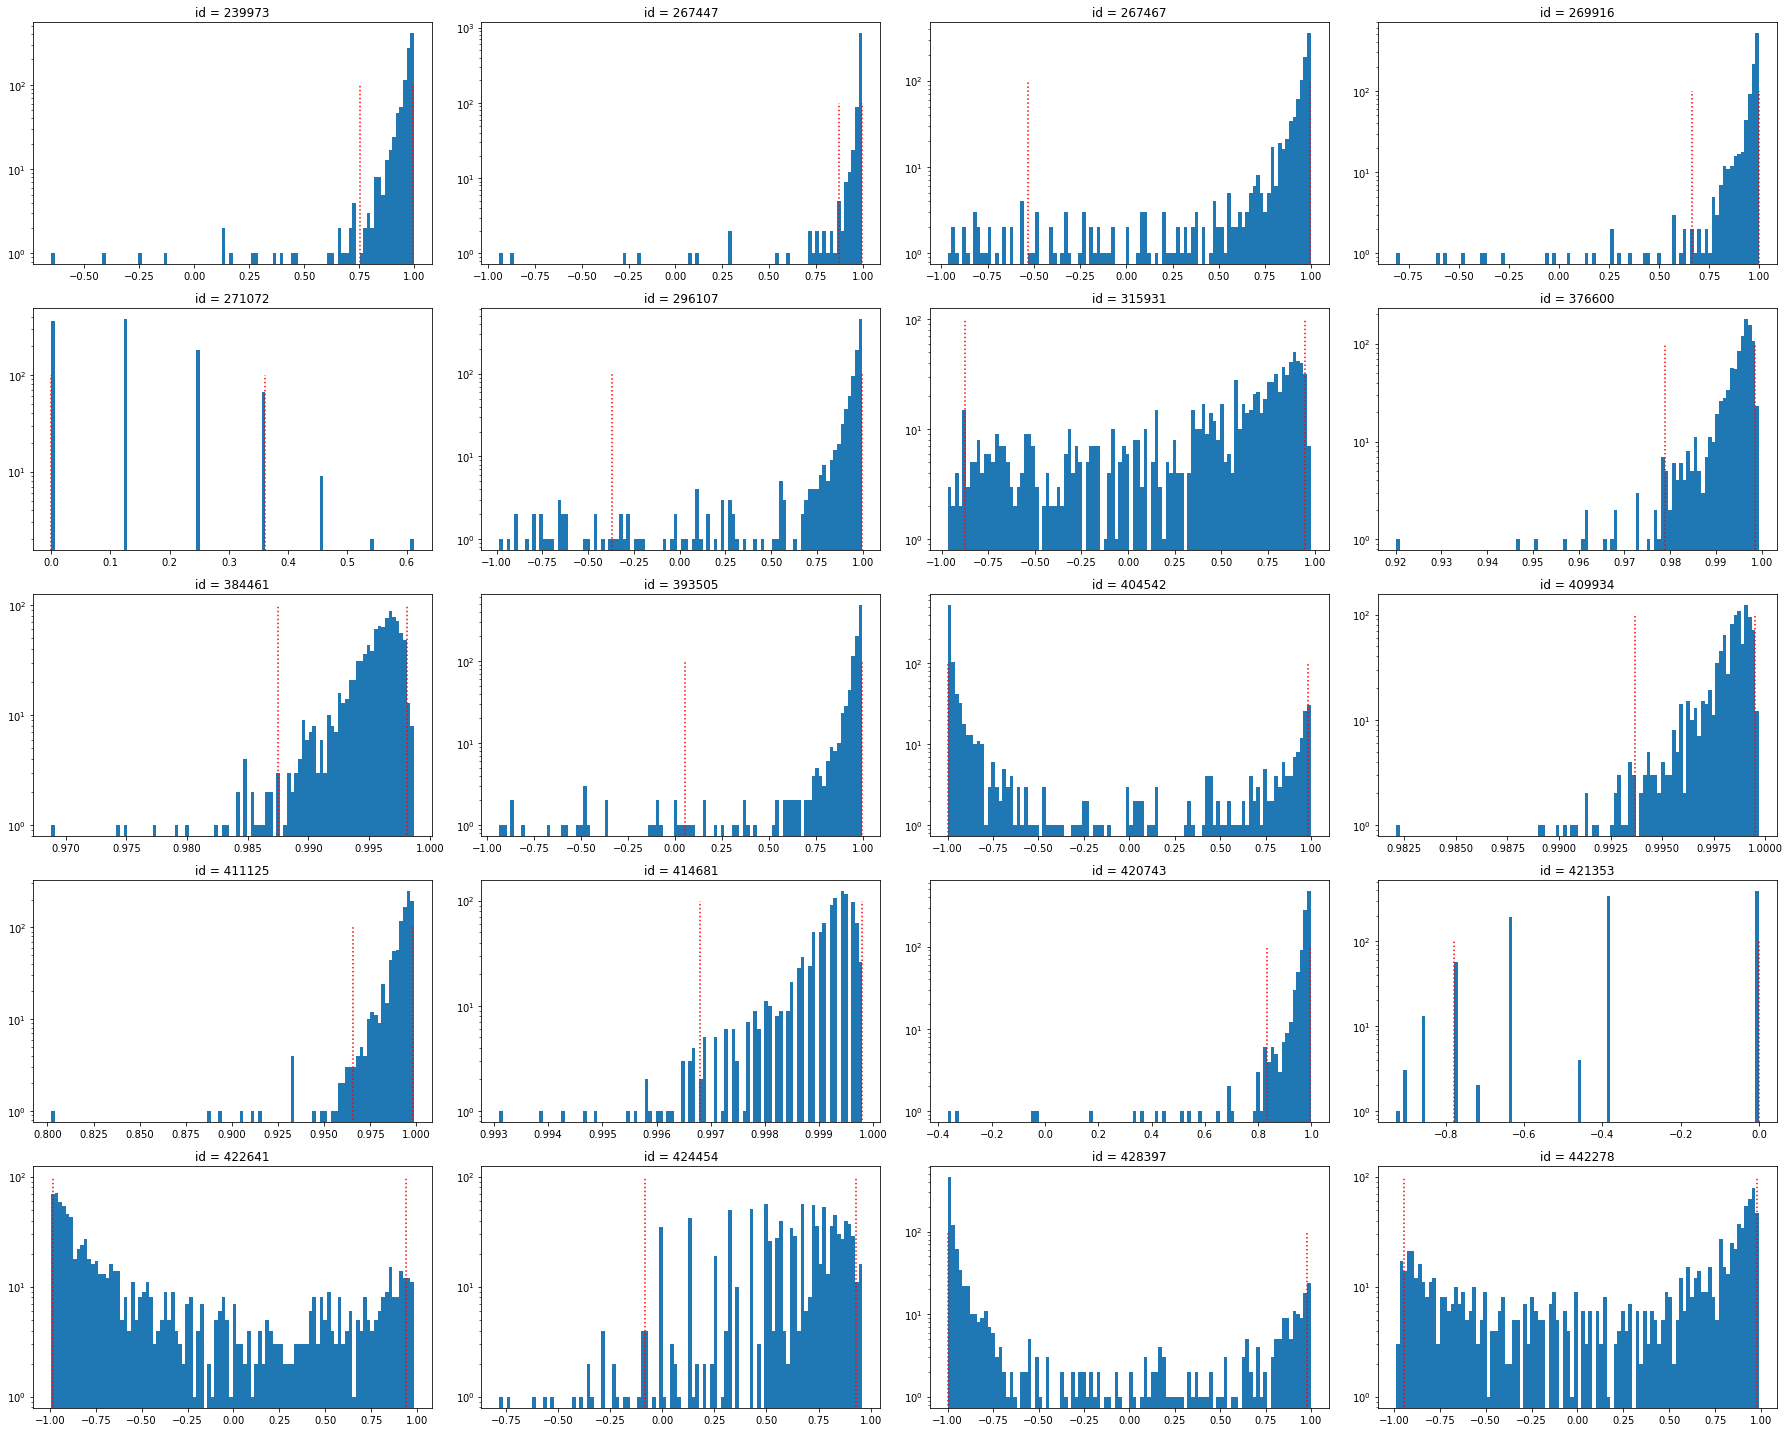

In [32]:
# PLOT ALL DISTRIBUTIONS
plt.figure(figsize=(25,20))

for i, dist in enumerate(articles_boot_dists): 
    plt.subplot(5,4,i+1)
    plt.hist(dist,bins = 100)
    plt.vlines(np.percentile(dist,97.5),0,100,linestyles='dotted',color = 'red')
    plt.vlines(np.percentile(dist,2.5),0,100,linestyles='dotted',color = 'red')
    plt.yscale('log')
    plt.title(f"id = {manual_label['id'][i]}")

plt.tight_layout()
plt.show()

**Note on the previous 20 articles**

We can identify three typical behaviors in the texts bootstrap distributions. First, we have a majority of unimodal 'well distributed' distributions (e.g. `id = 267447`). This are not concerning and seem valid distributions on which a regualar $CI$ can be computed. Seconldy, we have some unimodal distribution with very sparse values (e.g. `id = 421353`). The reason for this appearance is that this texts are much shorte and therefore there is many less possible new texts arising from the bootstrap, resulting in just a few possible values for the sentiment to take. Although strange looking, this distributions are also not considered problematic when performing computing a regular $CI$. Finally, we also observe some bi-modal distributions (e.g. `id = 428297`). This distributions are problematic as a regular $CI$ is designed for unimodal distributions. In order to perform a signficance test on this bimodal distributions an appropriate $CI$ is designed.

 Bloomberg Opinion     It s almost universally expected in India that the central bank s monetary policy committee will lower interest rates this week  Many expect it to keep cutting until the policy rate hits 5  by the end of the year  it was 6  in June  and the committee cut it by an unexpected 0 35 percentage points in its last meeting to bring it down to 5 4   The arguments for a cut are manifold  The Indian economy is clearly spluttering  with growth coming in at a shocking 5  in the last quarter for which data is available  consumer price inflation stands at 3 2   well below the Reserve Bank of India s mid point target of 4   and industry is loudly complaining that high real rates are depressing investment 
Even the hawkish monetary policy committee  which critics complain has consistently over estimated inflation in the past  is unlikely to be able to ignore that combination of factors  RBI Governor Shaktikanta Das told the Bloomberg India Economic Forum last month that  there s

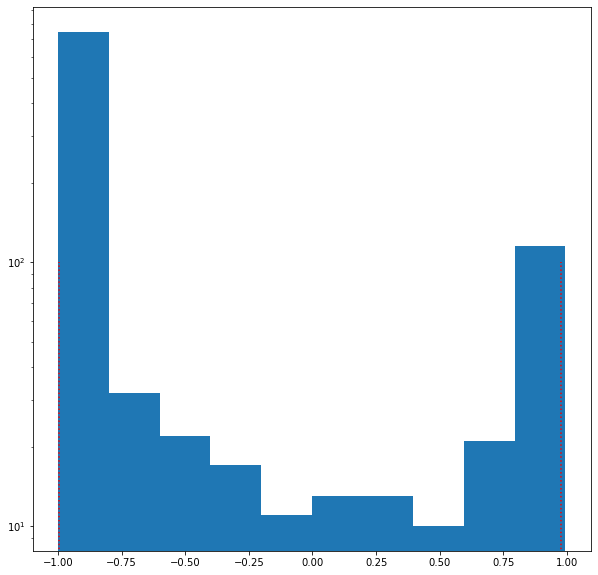

In [36]:
# CODE TO PLOT/STUDY A SINGLE TEXT DISTRIBUTION (EXPLORATORY)
an_id = 428397
an_article = str(news_sent[news_sent['id'] == an_id].content.values[0])
print(an_article)

n = 10**3
scores = []
for i in range(n): 
    new_article = new_text(an_article)
    scores.append(measure_sentiment(new_article))

plt.figure(figsize = [10,10])
plt.hist(scores,bins = 10,)
plt.vlines(np.percentile(scores,97.5),0,100,linestyles='dotted',color = 'red')
plt.vlines(np.percentile(scores,2.5),0,100,linestyles='dotted',color = 'red')
plt.yscale('log')
plt.show()

array([463., 115.,  57.,  34.,  25.,  18.,  14.,  11.,   3.,   6.,   5.,
         5.,   5.,   3.,   3.,   2.,   3.,   0.,   2.,   4.,   2.,   3.,
         2.,   5.,   1.,   1.,   3.,   2.,   2.,   1.,   1.,   1.,   3.,
         1.,   3.,   1.,   2.,   0.,   3.,   2.,   1.,   3.,   2.,   0.,
         2.,   1.,   0.,   1.,   0.,   1.,   0.,   1.,   2.,   2.,   1.,
         1.,   2.,   0.,   2.,   2.,   0.,   0.,   1.,   0.,   0.,   1.,
         2.,   4.,   3.,   2.,   1.,   1.,   2.,   1.,   2.,   0.,   2.,
         1.,   0.,   0.,   2.,   3.,   2.,   2.,   1.,   2.,   1.,   1.,
         2.,   5.,   4.,   5.,   7.,   3.,   6.,  13.,  11.,   9.,  27.,
        30.])

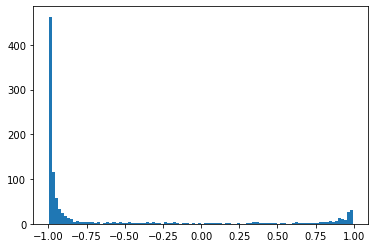

In [50]:
a_hist = plt.hist(scores,bins = 100,)

# (heights, left-bin boundary)

# CHOOSE BINS UNTIL 95% IS REACHED
ci_bins = []
i = 0

while (sum(ci_bins)/1000)<0.95:
    ci_bins.append(sorted(heights,reverse = True)[i])
    i += 1

len(ci_bins)

Julia Louis Dreyfus signs a multiyear overall deal with Apple s  AAPL  0 5   new streaming platform and will develop exclusive content as both an executive producer and a star 
Financial terms weren t disclosed 
Former HBO CEO Richard Plepler recently inked a five year production pact with Apple TV   Plepler greenlit Louis Dreyfus  acclaimed Veep series while he was heading the premium cable network 
Sources say the Louis Dreyfus deal was already in negotiations while Plepler was finalizing his deal 


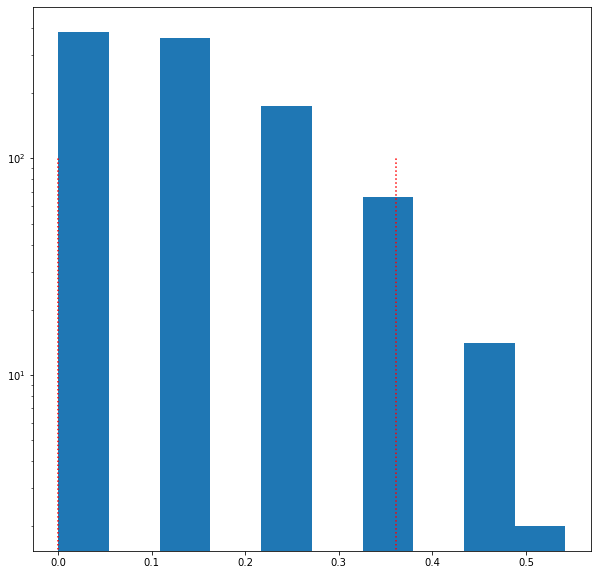

In [29]:
# CODE TO PLOT/STUDY A SINGLE TEXT DISTRIBUTION (EXPLORATORY)
an_id = 271072
an_article = str(news_sent[news_sent['id'] == an_id].content.values[0])
print(an_article)

n = 10**3
scores = []
for i in range(n): 
    new_article = new_text(an_article)
    scores.append(measure_sentiment(new_article))

plt.figure(figsize = [10,10])
plt.hist(scores,bins = 10,)
plt.vlines(np.percentile(scores,97.5),0,100,linestyles='dotted',color = 'red')
plt.vlines(np.percentile(scores,2.5),0,100,linestyles='dotted',color = 'red')
plt.yscale('log')
plt.show()

This extra test involves computing the *Pearson correlation* between the human score and the measured score for the $20$ sample articles and, through bootstraping, testing if it signifacntly different than $0$. This bootstrap procedures involves generating the $H_0$ distribution (i.e. the distribution of $r$ values that we would expect if there was no correlation between the two scores) by shuffling one of the two score vectors, and performing a *Pearson correlation* with the other unshufled score vector. Performing this, for instance, $10^4$ times would generate a good estimate of the $H_0$ distribution and we can test whether our actual $r$ value belongs to this distribution with an $\alpha = 0.05$. 

In [20]:
# VECTOR WITH MESURED SCORES FOR THE SAMPLE
both_scores = news_sent[news_sent['id'].isin(manual_label.id)]
both_scores = both_scores.merge(manual_label,on = 'id')[['dic_sentiment','h_score']]

# USING A TEMPORARY RANDOM HUMAN SCORE
# h_scores = [(0.1+1.2*x)+np.random.normal(0,0.2,1)[0] for x in m_scores]
m_scores = list(both_scores['dic_sentiment'])
h_scores = list(both_scores['h_score'])

# ACUTAL CORRELATION COEFFICIENT
actual_cor = np.corrcoef(h_scores,m_scores)[0][1]
actual_cor

0.6272349287405868

In [53]:
# CREATING A NULL DISTRIBUTION OF CORRELATION VALUES THROUGH BOOTSTRAP
n = 10**4
cor_coefs = []
for i in range(n):
    new_h_scores = random.sample(h_scores,len(h_scores))
    cor_coefs.append(np.corrcoef(m_scores,new_h_scores)[0][1])

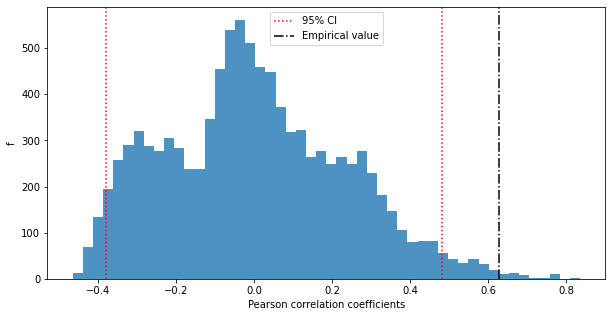

In [54]:
plt.figure(figsize = [10,5])
plt.hist(cor_coefs,bins = 50,alpha = 0.8)
plt.axvline(x = np.percentile(cor_coefs,97.5),color = 'red', linestyle = 'dotted',label = '95% CI')
plt.axvline(x = np.percentile(cor_coefs,2.5),color = 'red', linestyle = 'dotted')
plt.axvline(x = actual_cor,color = 'black', linestyle = 'dashdot',label = 'Empirical value')
plt.xlabel('Pearson correlation coefficients')
plt.ylabel('f')
plt.legend()
plt.show()


A second test will test the (?) precission and bias of the measured score, against the baseline truth of the human score. This will be done by means of a linear regression analysis between these two quantities. 

In [26]:
# DEFINE FUNCTION TO ESTIMATE LINEAR REGRESION PARAMETERS FOR THE SAMPLE
def loglikelihood_lrm(alpha, beta, sigma_y, sample):
    tot_loglike = 0
    for point in sample: 
        x = point[0]
        y = point[1]
        loglike = np.log(st.norm.pdf(y,alpha + x*beta, sigma_y))
        tot_loglike += loglike
        
    return tot_loglike  

def fit_lrm(sample,initial_alpha=1,initial_beta=1, initial_sigma=1):

    params = [initial_alpha,initial_beta,initial_sigma]
    params_like = loglikelihood_lrm(params[0],params[1],params[2],sample)

    variations = [100,10,1,0.5,0.1]
    for var in variations:
        
        for i in range(1000):
            new_params = [np.random.normal(params[0],var),np.random.normal(params[1],var),np.random.normal(params[2],var)]
            new_like = loglikelihood_lrm(new_params[0],new_params[1],new_params[2],sample)

            if new_like > params_like:
                params = new_params
                params_like = new_like

    return params

# ESTIMATE PARAMETERS 
sample = []
for i in range(len(h_scores)):
    sample.append((m_scores[i],h_scores[i]))

params = fit_lrm(sample)

C:\Users\user\AppData\Local\Temp/ipykernel_13976/154784733.py:36: RuntimeWarning: invalid value encountered in log
  h_scores_log = [np.log(x) for x in h_scores]
C:\Users\user\AppData\Local\Temp/ipykernel_13976/154784733.py:7: RuntimeWarning: divide by zero encountered in log
  loglike = np.log(st.norm.pdf(y,alpha + x*beta, sigma_y))


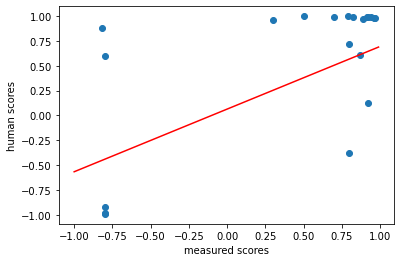

In [29]:
# PLOTTING THE REGRESSIO LINE 

line = [params[0] + params[1]*x for x in np.arange(-1,1,0.01)]

plt.scatter(h_scores,m_scores)
plt.plot(np.arange(-1,1,0.01),line,'r-')
plt.xlabel('measured scores')
plt.ylabel('human scores')
plt.show()

C:\Users\user\AppData\Local\Temp/ipykernel_13976/154784733.py:7: RuntimeWarning: divide by zero encountered in log
  loglike = np.log(st.norm.pdf(y,alpha + x*beta, sigma_y))


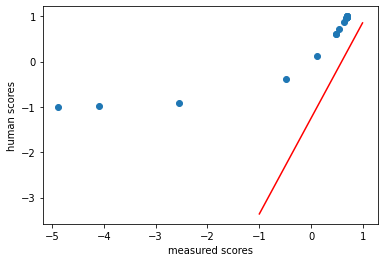

In [34]:
# TRYING A REGRESSION WITH THE Y-AXIS' ALGORITHM
m_scores_log = [np.log((x+1)) for x in m_scores]
h_scores_big = [x+1 for x in h_scores]
trans_sample = []
for i in range(len(h_scores)):
    trans_sample.append((m_scores[i],m_scores_log[i]))

params_trns = fit_lrm(trans_sample)

line = [params_trns[0] + params_trns[1]*x for x in np.arange(-1,1,0.01)]
plt.scatter(m_scores_log,m_scores)
plt.plot(np.arange(-1,1,0.01),line,'r-')
plt.xlabel('measured scores')
plt.ylabel('human scores')
plt.show()